<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Remote%20Sensing/image_classification__dnn_h2o_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network - Supervised Image Classification in H20 R

Zia Ahmed, University at Buffalo

H2O’s Deep Learning is based on a multi-layer feedforward artificial neural netmax-outained with stochastic gradient descent using a bacmanye network. It can contain many hidden layers consisting of neurons with tanh, rectifier, and max out activation functions. Advanced features such as adaptive learning rate, rate annealing, momentum training, dropout, L1 or L2 regularization, checkpointing, and grid search enable high predictive accuracy. Each compute node trains a copy of the global model parameters on its local data with multi-threading (asynchronously) and contributes periodically to the global model via model averaging across the network.

H2O is a powerful, open-source platform that lets you build machine learning models and predictive analytics on big data. It's written in Java and can read data from a distributed and local cluster. You can access H2O's capabilities from any external program or script using JSON over HTTP. H2O's web interface, R binding, and Python binding all use the Rest API.

### Insatll rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
  Using cached rpy2-3.5.1-cp310-cp310-linux_x86_64.whl


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install Required Packages

In [ ]:
%%R
pkg <- c('tidyverse', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools', 'data.table')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')


#### Install h2o

In [ ]:
%%R
pkgs <- c("RCurl","jsonlite")
for (pkg in pkgs) {
  if (! (pkg %in% rownames(installed.packages(lib='drive/My Drive/R/')))) { install.packages(pkg) }
}
install.packages("h2o", type="source",lib='drive/My Drive/R/', repos="https://h2o-release.s3.amazonaws.com/h2o/rel-3.42.0/2/R")

### Load Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library (terra)
library (tidyterra)
library(tidymodels)
library(sf)
library(raster)
library(rgdal)
library(tidyverse)
library(raster)
library(RColorBrewer)
library(RStoolbox)
library(gridExtra)
library(data.table)

### Data

In this lesson, we will use a sub-set of Landsat 9 satellite covering the central part of the country. We have already prepared this data and will use them for pixel-based classification using h2o-DNN model in R.

We will train the DNN model with four feature classes extracted from Google Earth imagery: (1) Home stage vegetation, (2) cropland, (3) Bare soil/Developed, and (4) water bodies.

The data  can be found [here](https://github.com/zia207/r-colab/tree/main/Data/DSM_AOI/Landsat_Subset/AOI_1).

In [12]:
%%R
# training data
point<-read_csv("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/point_data_class.csv") %>%
glimpse()

Rows: 215854 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Class, Description
dbl (10): x, y, Id, B2, B3, B4, B5, B6, B7, dem

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 215,854
Columns: 12
$ x           <dbl> 152170, 152180, 152000, 152010, 152020, 152030, 152040, 15…
$ y           <dbl> 2588310, 2588310, 2588300, 2588300, 2588300, 2588300, 2588…
$ Id          <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ B2          <dbl> 12573, 12554, 12559, 12559, 12559, 12577, 12577, 12577, 12…
$ B3          <dbl> 14378, 14299, 14336, 14336, 14336, 14338, 14338, 14338, 14…
$ B4          <dbl> 15320, 15181, 15347, 15347, 15347, 15272, 15272, 15272, 15…
$ B5          <dbl> 18372, 18142, 18525, 18525, 18525, 18304, 18304, 18304, 18…
$ B6          <dbl> 21751, 21507, 21824, 21824, 21824, 21778,

In [13]:
%%R
# training data
point.df<-point[,4:11] %>%
glimpse()

Rows: 215,854
Columns: 8
$ B2    <dbl> 12573, 12554, 12559, 12559, 12559, 12577, 12577, 12577, 12605, 1…
$ B3    <dbl> 14378, 14299, 14336, 14336, 14336, 14338, 14338, 14338, 14333, 1…
$ B4    <dbl> 15320, 15181, 15347, 15347, 15347, 15272, 15272, 15272, 15257, 1…
$ B5    <dbl> 18372, 18142, 18525, 18525, 18525, 18304, 18304, 18304, 18288, 1…
$ B6    <dbl> 21751, 21507, 21824, 21824, 21824, 21778, 21778, 21778, 21682, 2…
$ B7    <dbl> 21393, 21176, 21448, 21448, 21448, 21467, 21467, 21467, 21421, 2…
$ dem   <dbl> 5.126486, 5.851623, 5.102431, 4.999510, 4.999510, 4.999510, 5.00…
$ Class <chr> "Class_3", "Class_3", "Class_3", "Class_3", "Class_3", "Class_3"…


In [15]:
%%R
# prediction grid
grid<-read_csv("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/prediction_grid_data.csv") %>%
glimpse()

Rows: 1000000 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): x, y, ID, B2, B3, B4, B5, B6, B7, dem

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1,000,000
Columns: 10
$ x   <dbl> 150930, 150960, 150990, 151020, 151050, 151080, 151110, 151140, 15…
$ y   <dbl> 2588550, 2588550, 2588550, 2588550, 2588550, 2588550, 2588550, 258…
$ ID  <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…
$ B2  <dbl> 9289, 9333, 9526, 9635, 9532, 9615, 9646, 9694, 9854, 9894, 9720, …
$ B3  <dbl> 10661, 10657, 10988, 11020, 10766, 10925, 11037, 10975, 11276, 112…
$ B4  <dbl> 10019, 10261, 10927, 11013, 10420, 10522, 10951, 10864, 11087, 112…
$ B5  <dbl> 18168, 17364, 16623, 16162, 16683, 17598, 16579, 16572, 16866, 160…
$ B6  <dbl> 14338, 14709, 15744, 15363, 15173, 15571, 15894, 15761, 16444, 157…
$ B7  <

In [16]:
%%R
# grid features
grid.df<-grid[,4:10] %>%
glimpse()

Rows: 1,000,000
Columns: 7
$ B2  <dbl> 9289, 9333, 9526, 9635, 9532, 9615, 9646, 9694, 9854, 9894, 9720, …
$ B3  <dbl> 10661, 10657, 10988, 11020, 10766, 10925, 11037, 10975, 11276, 112…
$ B4  <dbl> 10019, 10261, 10927, 11013, 10420, 10522, 10951, 10864, 11087, 112…
$ B5  <dbl> 18168, 17364, 16623, 16162, 16683, 17598, 16579, 16572, 16866, 160…
$ B6  <dbl> 14338, 14709, 15744, 15363, 15173, 15571, 15894, 15761, 16444, 157…
$ B7  <dbl> 11357, 11819, 13262, 12782, 12286, 12710, 13399, 12748, 14141, 137…
$ dem <dbl> 9.827662, 14.767797, 2.985770, 2.595814, 2.571604, 8.822142, 3.505…


In [17]:
%%R
# grid prediction location
grid.xy<-grid[c(1:2)]

### Import h20

In [51]:
%%R
.libPaths('drive/My Drive/R')
library(h2o)
h2o.init()
#disable progress bar
h2o.no_progress()
# Optional: remove anything from previous session
h2o.removeAll()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpodZX4A/file660379ff08c4/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpodZX4A/file6603c3d4ad8/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: ...... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 seconds 46 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.42.0.2 
    H2O cluster version age:    2 months 
    H2O cluster name:           H2O_started_from_R_root_rkq134 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.17 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:            

### Import data to h2o cluster

In [52]:
%%R
df<-  as.h2o(point.df)
grid<- as.h2o(grid.df)


### Split data

In [55]:
%%R
df$Class= as.factor(df$Class)
splits <- h2o.splitFrame(df, c(0.6,0.2), seed=1234)
train  <- h2o.assign(splits[[1]], "train.hex") # 60%
valid  <- h2o.assign(splits[[2]], "valid.hex") # 20%
test   <- h2o.assign(splits[[3]], "test.hex")  # 20%

#### Define response and predictors

In [56]:
%%R
response <- "Class"
predictors <- setdiff(names(df), response)
predictors

[1] "B2"  "B3"  "B4"  "B5"  "B6"  "B7"  "dem"


## Fit DNN model

We will fit DNN model with following parameters:

standardize: logical. If enabled, automatically standardize the data.

distribution:

activation: Specify the activation function. One of:

  - tanh
  
  - tanh_with_dropout
  
  - rectifier (default)
  
  - rectifier_with_dropout

  - maxout (not supported when autoencoder is enabled)
  
  - maxout_with_dropout
  
hidden: Specify the hidden layer sizes (e.g., (100,100)). The value must be positive. This option defaults to (200,200).

adaptive_rate: Specify whether to enable the adaptive learning rate (ADADELTA). This option defaults to True (enabled).

epochs: Specify the number of times to iterate (stream) the dataset. The value can be a fraction. This option defaults to 10.

epsilon: (Applicable only if adaptive_rate=True) Specify the adaptive learning rate time smoothing factor to avoid dividing by zero. This option defaults to 1e-08.

input_dropout_ratio: Specify the input layer dropout ratio to improve generalization. Suggested values are 0.1 or 0.2. This option defaults to 0.

l1: Specify the L1 regularization to add stability and improve generalization; sets the value of many weights to 0 (default).

l2: Specify the L2 regularization to add stability and improve generalization; sets the value of many weights to smaller values. Defaults to 0.

max_w2: Specify the constraint for the squared sum of the incoming weights per unit (e.g. for rectifier). Defaults to 3.4028235e+38.

momentum_start: (Applicable only if adaptive_rate=False) Specify the initial momentum at the beginning of training; we suggest 0.5. This option defaults to 0.

rate: (Applicable only if adaptive_rate=False) Specify the learning rate. Higher values result in a less stable model, while lower values lead to slower convergence. This option defaults to 0.005.

rate_annealing: Learning rate decay, (Applicable only if adaptive_rate=False) Specify the rate annealing value. rate(1+ rate_annealing × samples), This option defaults to 1e-06.

rate_decay: (Applicable only if adaptive_rate=False) Specify the rate decay factor between layers. N-th layer: rate × rate_decay(n−1). This options defaults to 1.

rho: (Applicable only if adaptive_rate is enabled) Specify the adaptive learning rate time decay factor. This option defaults to 0.99.

shuffle_training_data: Specify whether to shuffle the training data. This option is recommended if the training data is replicated and the value of train_samples_per_iteration is close to the number of nodes times the number of rows. This option defaults to False (disabled).

stopping_tolerance = Relative tolerance for metric-based stopping criterion

stopping_rounds = Early stopping based on convergence of stopping_metric.Defaults to 5.

stopping_metric = Metric to use for early stopping

variable_importances: Specify whether to compute variable importance. This option defaults to True (enabled).

In [57]:
%%R
dnn_model <- h2o.deeplearning(
                       model_id="DNN_model_ID",
                       training_frame= train,
                       validation_frame= valid,
                       x=predictors,
                       y=response,
                       distribution ="AUTO",
                       standardize = TRUE,
                       shuffle_training_data = TRUE,
                       activation = "Rectifier",
                       hidden = c(128, 128, 100),
                       epochs = 100,
                       adaptive_rate = TRUE,
                       rate = 0.001,
                       rate_annealing = 1e-06,
                       rate_decay = 1,
                       rho = 0.99,
                       epsilon = 1e-08,
                       momentum_start = 0.2,
                       momentum_stable =0.6,
                       input_dropout_ratio = 0.0001,
                       l1 = 0.0005,
                       l2 = 0.0001,
                       max_w2 = 3.4028235e+38,
                       stopping_tolerance = 0.001,
                       stopping_rounds = 2,
                       stopping_metric = "logloss",
                       nfolds = 5,
                       keep_cross_validation_models = TRUE,
                       keep_cross_validation_predictions = TRUE,
                       variable_importances = TRUE,
                       seed=1256
                       )

### The Model Summary

In [58]:
%%R
summary(dnn_model)

Model Details:

H2OMultinomialModel: deeplearning
Model Key:  DNN_model_ID 
Status of Neuron Layers: predicting Class, 4-class classification, multinomial distribution, CrossEntropy loss, 30,840 weights/biases, 370.5 KB, 1,458,409 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1     7     Input  0.01 %       NA       NA        NA       NA       NA
2     2   128 Rectifier  0.00 % 0.000500 0.000100  0.032737 0.073771 0.000000
3     3   128 Rectifier  0.00 % 0.000500 0.000100  0.196245 0.148931 0.000000
4     4   100 Rectifier  0.00 % 0.000500 0.000100  0.168143 0.128543 0.000000
5     5     4   Softmax      NA 0.000500 0.000100  0.299844 0.229250 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2    0.003558   0.117847  0.025694 0.086135
3   -0.001488   0.044447  0.042777 0.304682
4   -0.000382   0.052717  0.011981 0.093022
5   -0.031798   0.292329  0.000779 0.008004



In [59]:
%%R
h2o.mean_per_class_error(dnn_model, train = TRUE, valid = TRUE, xval = TRUE)

    train     valid      xval 
0.1144600 0.1116696 0.1091849 


### Soring

In [60]:
%%R
scoring_history<-dnn_model@model$scoring_history
scoring_history

Scoring History: 
             timestamp          duration training_speed   epochs iterations
1  2023-09-26 02:16:43         0.000 sec             NA  0.00000          0
2  2023-09-26 02:16:51 11 min  3.764 sec   2015 obs/sec  0.13466          1
3  2023-09-26 02:17:10 11 min 22.674 sec   2672 obs/sec  0.53634          4
4  2023-09-26 02:17:27 11 min 38.741 sec   3861 obs/sec  1.20740          9
5  2023-09-26 02:17:43 11 min 54.702 sec   5683 obs/sec  2.40998         18
6  2023-09-26 02:17:58 12 min 10.568 sec   7272 obs/sec  3.88046         29
7  2023-09-26 02:18:15 12 min 27.599 sec   8606 obs/sec  5.62067         42
8  2023-09-26 02:18:31 12 min 42.885 sec   9516 obs/sec  7.22779         54
9  2023-09-26 02:18:46 12 min 58.761 sec  10317 obs/sec  8.96693         67
10 2023-09-26 02:19:04 13 min 17.773 sec  11053 obs/sec 10.97675         82
11 2023-09-26 02:19:09 13 min 22.803 sec  11118 obs/sec 11.24448         84
          samples training_rmse training_logloss training_r2
1        

### Plot the classification error

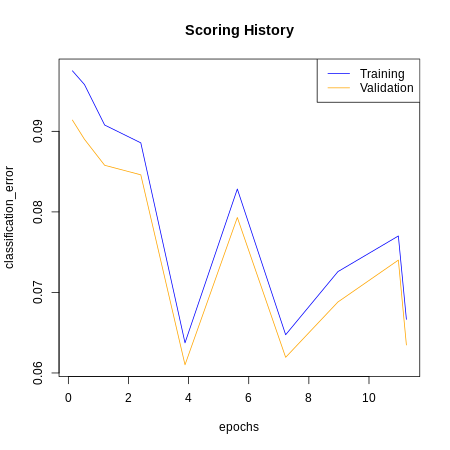

In [61]:
%%R -w 450 -h 450 -u px
plot(dnn_model,
     timestep = "epochs",
     metric = "classification_error")

### Confusion matrix

In [62]:
%%R
# training
train.cf<-h2o.confusionMatrix(dnn_model)
print(train.cf)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
        Class_1 Class_2 Class_3 Class_4  Error          Rate
Class_1    1714     431      12      10 0.2090 = 453 / 2,167
Class_2      17    5772      12      40 0.0118 =  69 / 5,841
Class_3      36      78     415       3 0.2199 =   117 / 532
Class_4       1      19       4    1383 0.0171 =  24 / 1,407
Totals     1768    6300     443    1436 0.0667 = 663 / 9,947


In [63]:
%%R
# validation
valid.cf<-h2o.confusionMatrix(dnn_model,valid=TRUE)
print(valid.cf)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
        Class_1 Class_2 Class_3 Class_4  Error             Rate
Class_1    7203    1752      52      60 0.2056 =  1,864 / 9,067
Class_2      57   25648      48     205 0.0119 =   310 / 25,958
Class_3     131     299    1683      18 0.2102 =    448 / 2,131
Class_4       9      94       9    5806 0.0189 =    112 / 5,918
Totals     7400   27793    1792    6089 0.0635 = 2,734 / 43,074


In [64]:
%%R
# test
test.cf<-h2o.confusionMatrix(dnn_model,test)
print(test.cf)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
        Class_1 Class_2 Class_3 Class_4  Error             Rate
Class_1    7302    1915      69      53 0.2181 =  2,037 / 9,339
Class_2      61   25203      55     212 0.0128 =   328 / 25,531
Class_3     101     338    1742      20 0.2085 =    459 / 2,201
Class_4      16      88       7    5898 0.0185 =    111 / 6,009
Totals     7480   27544    1873    6183 0.0681 = 2,935 / 43,080


### Grid Prediction

In [65]:
%%R
g.predict = as.data.frame(h2o.predict(object = dnn_model,
                                      newdata = grid))

### Stop h2o cluster

In [66]:
%%R
h2o.shutdown(prompt=FALSE)

### Extract Prediction Class

In [67]:
%%R
grid.xy$Class<-g.predict$predict
head(grid.xy)

# A tibble: 6 × 3
       x       y Class  
   <dbl>   <dbl> <fct>  
1 150930 2588550 Class_2
2 150960 2588550 Class_2
3 150990 2588550 Class_2
4 151020 2588550 Class_2
5 151050 2588550 Class_2
6 151080 2588550 Class_2


In [68]:
%%R
ID<-read_csv("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/landuse_id.csv")
ID

Rows: 4 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Class, Description
dbl (1): Id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 4 × 3
     Id Class   Description         
  <dbl> <chr>   <chr>               
1     0 Class_1 Homestead vegetation
2     1 Class_2 Cropland            
3     2 Class_3 Bare soil/Developed 
4     3 Class_4 Water body          


In [69]:
%%R
# Join landuse ID
grid.new<-inner_join(grid.xy, ID)
# Omit missing values
grid.new.na<-na.omit(grid.new)
head(grid.new.na)

Joining with `by = join_by(Class)`
# A tibble: 6 × 5
       x       y Class      Id Description
   <dbl>   <dbl> <chr>   <dbl> <chr>      
1 150930 2588550 Class_2     1 Cropland   
2 150960 2588550 Class_2     1 Cropland   
3 150990 2588550 Class_2     1 Cropland   
4 151020 2588550 Class_2     1 Cropland   
5 151050 2588550 Class_2     1 Cropland   
6 151080 2588550 Class_2     1 Cropland   


### Convert to raster

In [70]:
%%R
x<-SpatialPointsDataFrame(as.data.frame(grid.new.na)[, c("x", "y")], data = grid.new.na)
r <- rasterFromXYZ(as.data.frame(x)[, c("x", "y", "Id")])

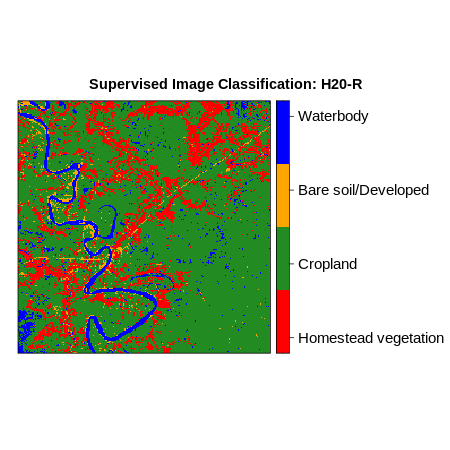

In [71]:
%%R -w 450 -h 450 -u px

# Create color palette
myPalette <- colorRampPalette(c("red","forestgreen","orange", "blue"))
# Plot Map
LU<-spplot(r,"Id", main="Supervised Image Classification: H20-R" ,
      colorkey = list(space="right",tick.number=1,height=1, width=1.5,
              labels = list(at = seq(0,3,length=4),cex=1.25,
              lab = c("Homestead vegetation" ,"Cropland", "Bare soil/Developed ", "Waterbody"))),
              col.regions=myPalette,cut=3)
LU